In [18]:
from torch.optim import Adam
import torch
import torchvision
from torchvision.transforms import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
from model import Model
import mlflow
import matplotlib.pyplot as plt
from einops import rearrange
import torch.nn.functional as F
import tempfile
from win10toast import ToastNotifier
import os
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Setup model + parameters

In [19]:
model = Model(num_classes=1)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model.to(device)

LR = 0.001
optimizer = Adam(model.parameters(), lr=LR)

EPOCHS = 15
IMG_SIZE = 32
BATCH_SIZE = 64
T = 300

Using device: cuda


# Datasets

In [20]:
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Randomly flip horizontally so we have slightly different images every epoch
    transforms.Pad(2),
    transforms.ToTensor(),
])

train = torchvision.datasets.FashionMNIST(root="./data", download=True, transform=data_transform, train=True)

test = torchvision.datasets.FashionMNIST(root="./data", download=True, transform=data_transform, train=False)


train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [21]:
# imgs, lbls = next(iter(train_dataloader))
# print(f"Image shape: {imgs.shape}, Labels shape: {lbls.shape}")

# def model_forward(model, imgs: torch.Tensor, t: torch.Tensor):
#     model.eval()
#     with torch.no_grad():
#         imgs = imgs.to(device)
#         noise_pred = model(imgs, t)
#         noise_pred = noise_pred.cpu().numpy()
#     return noise_pred

# noise_pred = model_forward(model, imgs, torch.empty((BATCH_SIZE, 1)).to(device))

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# axes[0].imshow(imgs[0].detach().cpu().squeeze(), cmap="gray")
# axes[1].imshow(noise_pred[0].squeeze(), cmap="gray")
# plt.show()

In [22]:
# t = torch.randint(1, 50, imgs.shape)

# imgs = imgs.to(device)
# noisy_imgs, noise, first_term, second_term = model.noise_scheduler(imgs, t)

# imgs = imgs.cpu()
# noisy_imgs = noisy_imgs.cpu()
# noise = noise.cpu()
# first_term = first_term.cpu()
# second_term = second_term.cpu()

# idx = 1
# img = imgs[idx]
# noisy_img = noisy_imgs[idx]
# noise_idx = noise[idx]
# first_term_idx = first_term[idx]
# second_term_idx = second_term[idx]

# plt.subplot(1, 4, 1)
# plt.imshow(rearrange(img, "b h w -> h w b"), cmap="gray")
# plt.title("Original Image")

# plt.subplot(1, 4, 2)
# plt.imshow(rearrange(noise_idx, "b h w -> h w b"), cmap="gray")
# plt.title("Noise")

# plt.subplot(1, 4, 3)
# plt.imshow(rearrange(noisy_img, "b h w -> h w b"), cmap="gray")
# plt.title("Noisy image")

# probably_original_image = noisy_img - first_term_idx - second_term_idx

# plt.subplot(1, 4, 4)
# plt.imshow(rearrange(probably_original_image, "b h w -> h w b"), cmap="gray")
# plt.title("Noisy image minus noise")

# plt.tight_layout()
# plt.show()

In [23]:
train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=data_transform)
test_dataset  = datasets.MNIST(root='../../data', train=False, download=True, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

Show noise schedule original image, noisy image, noise, and noisy image minus the noise

In [24]:
# noise_sched = model.noise_scheduler
# images, labels = next(iter(train_loader))

# # Forward diffusion for the first image
# image = images[0].to(device)
# timestep = 100
# noisy_img, noise, first_term, second_term = noise_sched.forward(image, timestep)

# # Noisy image minus the noise
# minus = noisy_img - second_term

# # Plot different images
# image = rearrange(image, "b h w -> h w b")
# noisy_img = rearrange(noisy_img, "b h w -> h w b")
# minus = rearrange(minus, "b h w -> h w b")
# second_term = rearrange(second_term, "b h w -> h w b")
# first_term = rearrange(first_term, "b h w -> h w b")
# noise = rearrange(noise, "b h w -> h w b")

# plt.subplot(1, 6, 1)
# plt.imshow(image.cpu().numpy(), cmap='gray')
# plt.title('Original')
# plt.axis('off')
# plt.subplot(1, 6, 2)
# plt.imshow(noisy_img.cpu().numpy(), cmap='gray')
# plt.title('Noisy img')
# plt.axis('off')
# plt.subplot(1, 6, 3)
# plt.imshow(second_term.cpu().numpy(), cmap='gray')
# plt.title('Second term')
# plt.axis('off')
# plt.axis('off')
# plt.subplot(1, 6, 4)
# plt.imshow(minus.cpu().numpy(), cmap='gray')
# plt.title('Minus')
# plt.axis('off')
# plt.subplot(1, 6, 5)
# plt.imshow(noise.cpu().numpy(), cmap='gray')
# plt.title('Noise')
# plt.axis('off')
# plt.subplot(1, 6, 6)
# plt.imshow(first_term.cpu().numpy(), cmap='gray')
# plt.title('First term')
# plt.axis('off')

# plt.subplots_adjust(wspace=1)  # adjust this value as needed

# plt.show()


Show noise schedule original image, noisy image, noise, 

# Train

In [25]:
EXPERIMENT_NAME = "MNIST_Training"

mlflow.end_run() # just in case

🏃 View run rumbling-smelt-878 at: http://127.0.0.1:5000/#/experiments/0/runs/2d4a26d72e6a4849bb48559d70794ac2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


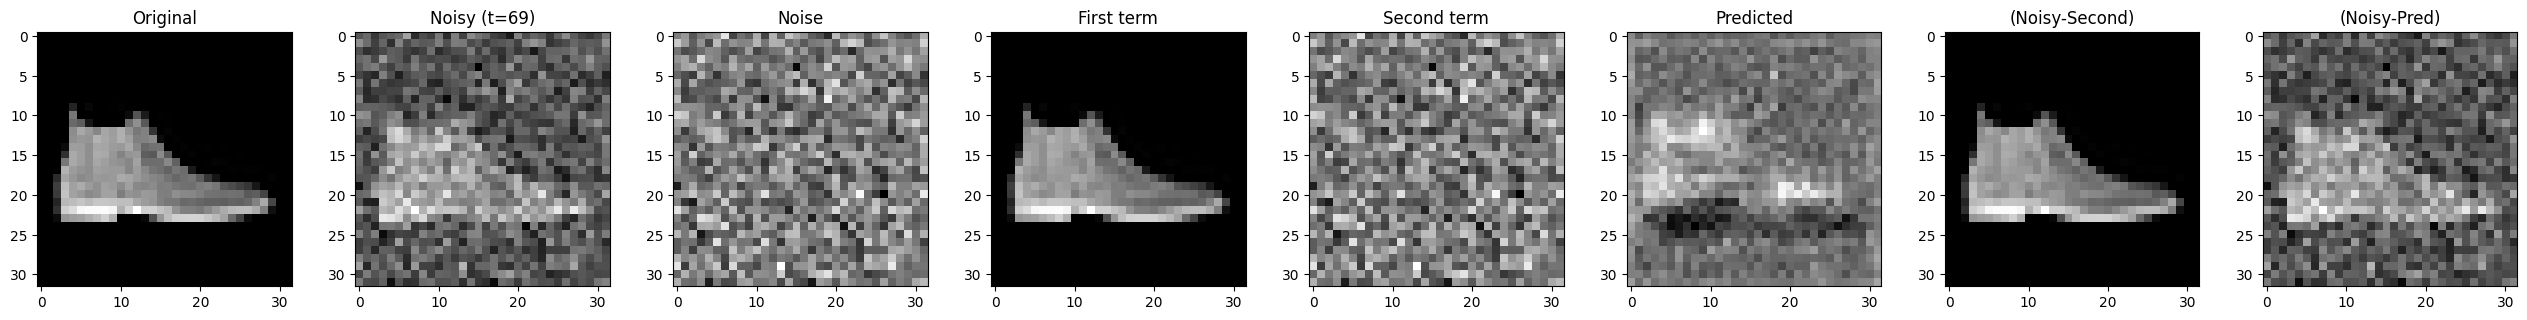

In [26]:
def log_plot_inference_and_fid_is_metrics(model, epoch, imgs, t, log_artifact: bool = True):
    """
    Plots the inference. Plots the original image, noisy image, first term, second term, predicted noise, and noisy image minus predicted noise.
    """
    x_noisy, noise, first_term, second_term = model.noise_scheduler(imgs, t)
    noise_pred = model(x_noisy, t)

    # Plot original image, noisy image, noise, and predicted noise
    idx = 0
    original_image = imgs[idx].cpu()
    noisy_image = x_noisy[idx].cpu()
    noise_idx = noise[idx].cpu()
    first_term_image = first_term[idx].cpu()
    second_term_image = second_term[idx].cpu()
    predicted_noise_image = noise_pred[idx].cpu().detach()
    t_idx = t[idx].cpu().item()
    minus = noisy_image - second_term_image
    noisy_minus_pred = noisy_image - predicted_noise_image

    num_of_subplots = 8
    subplot_index = 0

    fig, axes = plt.subplots(1, num_of_subplots, figsize=(32, 32))
    axes[subplot_index].imshow(rearrange(original_image, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("Original")
    subplot_index += 1

    axes[subplot_index].imshow(rearrange(noisy_image, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("Noisy (t="+str(t_idx)+")")
    subplot_index += 1

    axes[subplot_index].imshow(rearrange(noise_idx, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("Noise")
    subplot_index += 1

    axes[subplot_index].imshow(rearrange(first_term_image, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("First term")
    subplot_index += 1

    axes[subplot_index].imshow(rearrange(second_term_image, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("Second term")
    subplot_index += 1

    axes[subplot_index].imshow(rearrange(predicted_noise_image, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("Predicted")
    subplot_index += 1

    axes[subplot_index].imshow(rearrange(minus, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("(Noisy-Second)")
    subplot_index += 1

    axes[subplot_index].imshow(rearrange(noisy_minus_pred, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("(Noisy-Pred)")
    subplot_index += 1


    plt.subplots_adjust(wspace=0.25)  # Increase gap between columns
    # plt.tight_layout()

    if log_artifact:
        img_name_prefix = EXPERIMENT_NAME + "_" + str(epoch) + "_"
        with tempfile.NamedTemporaryFile(prefix=img_name_prefix, suffix=".png", delete=False) as tmp:
            fig.savefig(tmp.name)
            mlflow.log_artifact(tmp.name, artifact_path="images")
        os.remove(tmp.name)
    else:
        plt.show()

    plt.close(fig)  # Clean up the figure

imgs, lbls = next(iter(test_dataloader))
imgs = imgs.to(device)
t = torch.randint(0, 100, (BATCH_SIZE,), device=device).long()
log_plot_inference_and_fid_is_metrics(model, 0, imgs, t, log_artifact=False)

# Metrics

FID

In [27]:
def get_fid_score(original_images, generated_images):
    """
    FID evaluates diversity of generated images (generated_images) with in a reference dataset (original_images)
    """
    # Convert grayscale (1-channel) images to 3-channel
    if original_images.shape[1] == 1:
        original_images = original_images.repeat(1, 3, 1, 1)
        generated_images = generated_images.repeat(1, 3, 1, 1)

    fid = FrechetInceptionDistance(normalize=True).to(original_images.device)
    fid.update(original_images, real=True)
    fid.update(generated_images, real=False)
    return fid.compute()

imgs, lbls = next(iter(test_dataloader))
imgs = imgs.to(device)

fid = get_fid_score(imgs, imgs)
print("When the input is the exact same tensors, we expect FID score of 0, which is indeed the case")
print("Same images FID:", fid)

When the input is the exact same tensors, we expect FID score of 0, which is indeed the case
Same images FID: tensor(-0.0001, device='cuda:0')


IS

In [28]:
def get_is_metrics(original_images, generated_images):
    # Convert grayscale (1-channel) images to 3-channel
    if original_images.shape[1] == 1:
        original_images = original_images.repeat(1, 3, 1, 1)
        generated_images = generated_images.repeat(1, 3, 1, 1)
    
    is_metric = InceptionScore(normalize=True).to(device)
    is_score_original, is_std_original = is_metric(original_images)
    is_score_generated, is_std_generated = is_metric(generated_images)
    return is_score_original, is_std_original, is_score_generated, is_std_generated

imgs, lbls = next(iter(test_dataloader))
imgs = imgs.to(device)

is_score_original, is_std_original, is_score_generated, is_std_generated = get_is_metrics(imgs, imgs)
print("When the input is the exact same tensors, we expect exact same IS score, and indeed that is the case")
print(f"IS Score:\t\t{is_score_original}, IS STD:\t\t{is_std_original}")
print(f"IS Generated Score:\t{is_score_generated}, IS Generated STD:\t{is_std_generated}")

c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


When the input is the exact same tensors, we expect exact same IS score, and indeed that is the case
IS Score:		2.6623878479003906, IS STD:		0.715976893901825
IS Generated Score:	2.5808441638946533, IS Generated STD:	0.6671846508979797


In [29]:
# def plot_fid_comparison(test_dataloader_iter, scheduler, noise_levels=[100, 500, 900]):
#     fig, axes = plt.subplots(3, 4, figsize=(12, 9))
#     fig.suptitle("Original vs Noised Images with FID", fontsize=16)
    
#     for row in range(3):
#         # Get next batch
#         batch = next(test_dataloader_iter)
#         if isinstance(batch, (tuple, list)):
#             original_image = batch[0][0].unsqueeze(0)  # single image, keep batch dim
#         else:
#             original_image = batch[0].unsqueeze(0)
        
#         original_image = original_image.to(next(scheduler.parameters()).device)
        
#         # Plot original
#         axes[row, 0].imshow(rearrange(original_image[0].cpu(), "c h w -> h w c"))
#         axes[row, 0].set_title("Original")
#         axes[row, 0].axis("off")

#         # Apply 3 noise levels
#         for col, t_idx in enumerate(noise_levels):
#             t = torch.tensor([t_idx], device=original_image.device)
#             noisy_img, *_ = scheduler(original_image, t)
#             fid_score = get_fid_score(original_image, noisy_img)

#             axes[row, col+1].imshow(rearrange(noisy_img[0].cpu(), "c h w -> h w c"))
#             axes[row, col+1].set_title(f"FID: {fid_score.item():.2f} (t={t_idx})")
#             axes[row, col+1].axis("off")

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
#     plt.show()

# plot_fid_comparison(test_dataloader_iter, )

In [30]:
def log_fid_is_metrics(model, epoch, imgs):
    # Add noise to the images
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    x_noisy, noise, first_term, second_term = model.noise_scheduler(imgs, t)

    # Get noise prediction
    noise_pred = model(x_noisy, t)

    # Remove the predicted noise from noisy image
    samples = x_noisy - noise_pred

    fid = get_fid_score(imgs, samples)
    is_score_original, is_std_original, is_score_generated, is_std_generated = get_is_metrics(imgs, samples)

    mlflow.log_metrics({
        "fid": fid,
        "is_score_original": is_score_original,
        "is_score_original_std": is_std_original,
        "is_score_generated": is_score_generated,
        "is_score_generated_std": is_std_generated,
    }, step=epoch)

Loss function

In [31]:
def get_loss(model, imgs: torch.Tensor, t: torch.Tensor):
    """
    Run loss function of the model for training
    """
    x_noisy, noise, first_term, second_term = model.noise_scheduler(imgs, t)
    noise_pred = model(x_noisy, t)
    loss = F.l1_loss(noise_pred, second_term) # Here we want to predict the noise. Second term is the noise / target to predict

    return loss

In [32]:
def log_checkpoint(model, epoch):
    """
    Save model checkpoint each epoch
    """
    checkpoint_path = f"checkpoint_epoch_{epoch}.pt"
    torch.save(model.state_dict(), checkpoint_path)
    mlflow.log_artifact(checkpoint_path, artifact_path="checkpoints")
    os.remove(checkpoint_path)

In [33]:
# mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# mlflow.autolog()

mlflow_run = mlflow.start_run()

mlflow.log_params({
    "lr": LR,
    "device": device,
    "optimizer": optimizer,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "image_size": IMG_SIZE,
    "T": T
})

mlflow.set_tag("Training Info", "Basic MNIST Fashion dataset")

In [ ]:
batch_step = 0
last_loss_epoch = -1
running_loss = 0 # Epoch running loss

iter_test_dataloader = iter(test_dataloader)

for epoch in tqdm(range(EPOCHS)):
    # Logs an image of different plots. Each subplot is different image (original, noisy, the noise, predicted noise and so on)
    log_plot_inference_and_fid_is_metrics(model, epoch, imgs, t)

    # Save checkpoint each epoch
    log_checkpoint(model, epoch)

    # Log FID, IS metrics
    imgs, lbls = next(iter_test_dataloader)
    imgs = imgs.to(device)
    log_fid_is_metrics(model, epoch, imgs)

    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        imgs, labels = batch
        imgs = imgs.to(device)
        # labels = labels.to(device)

        # Get loss and log it and run inference and save result if mlflow_log_loss
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, imgs, t)
        running_loss += loss

        mlflow.log_metric("batch_loss", loss.item(), step=batch_step)
        batch_step += 1

        # Calculate gradients and update model parameters
        loss.backward()
        optimizer.step()

    running_loss = (running_loss / batch_step).item()
    mlflow.log_metric("epoch_loss", running_loss, epoch)


  7%|▋         | 1/15 [01:02<14:32, 62.29s/it]

Epoch: 0 Epoch loss: tensor(0.0652, device='cuda:0', grad_fn=<DivBackward0>)


 13%|█▎        | 2/15 [02:04<13:25, 61.98s/it]

Epoch: 1 Epoch loss: tensor(0.0228, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 3/15 [03:05<12:22, 61.87s/it]

Epoch: 2 Epoch loss: tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>)


 27%|██▋       | 4/15 [04:05<11:10, 61.00s/it]

Epoch: 3 Epoch loss: tensor(0.0103, device='cuda:0', grad_fn=<DivBackward0>)


 33%|███▎      | 5/15 [05:07<10:12, 61.23s/it]

Epoch: 4 Epoch loss: tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 6/15 [06:07<09:07, 60.85s/it]

Epoch: 5 Epoch loss: tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)


 47%|████▋     | 7/15 [07:06<08:03, 60.42s/it]

Epoch: 6 Epoch loss: tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)


 53%|█████▎    | 8/15 [08:06<07:02, 60.29s/it]

Epoch: 7 Epoch loss: tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 9/15 [09:06<06:01, 60.21s/it]

Epoch: 8 Epoch loss: tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>)


 67%|██████▋   | 10/15 [10:06<05:00, 60.15s/it]

Epoch: 9 Epoch loss: tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)


 73%|███████▎  | 11/15 [11:06<03:59, 59.95s/it]

Epoch: 10 Epoch loss: tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 12/15 [12:06<02:59, 59.95s/it]

Epoch: 11 Epoch loss: tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>)


 87%|████████▋ | 13/15 [13:06<01:59, 59.89s/it]

Epoch: 12 Epoch loss: tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)


 93%|█████████▎| 14/15 [14:05<00:59, 59.91s/it]

Epoch: 13 Epoch loss: tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 15/15 [15:07<00:00, 60.47s/it]

Epoch: 14 Epoch loss: tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)


Save model

In [36]:
# torch.save(model.state_dict(), "model.pth")
mlflow.pytorch.log_model(model, artifact_path="models")

2025/06/02 00:51:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/02 00:52:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/02 00:52:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Generate images (the whole point of the model)

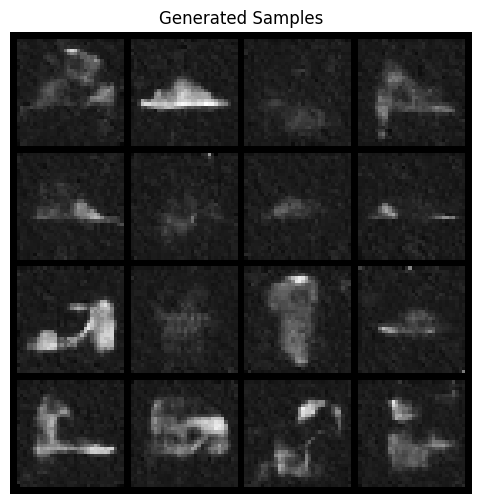

In [90]:
with torch.no_grad():
    # Generate 16 random noise samples
    num_images = 16
    img_shape = (num_images, 1, IMG_SIZE, IMG_SIZE)
    img = torch.randn(img_shape).to(device)
    t = torch.zeros(num_images, dtype=torch.long).to(device)  # dummy timesteps

    # Predict noise and denoise
    noise_pred = model(img, t)
    img = img - noise_pred

    # Convert to grid for plotting
    grid = torchvision.utils.make_grid(img, nrow=4, normalize=True)  # normalize for display
    grid = grid.permute(1, 2, 0).cpu().numpy()  # CHW -> HWC

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.squeeze(), cmap="gray")  # squeeze if single channel
    plt.axis("off")
    plt.title("Generated Samples")
    plt.show()


Load model

In [ ]:
# # Load model
# model = Model()
# model.load_state_dict(torch.load("model.pth"))



In [37]:
mlflow.end_run()

🏃 View run nimble-fawn-319 at: http://127.0.0.1:5000/#/experiments/0/runs/0c93e32a8458449fa8f73d4705758e0f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Notify windows that we finished running notebook

In [38]:
if os.name == 'nt':
    notifier = ToastNotifier()
    notifier.show_toast("Notebook Run Complete", "Training finished.", duration=10, threaded=True)

WNDPROC return value cannot be converted to LRESULT
